# Analysing market opportunities using SQL

The goal of this project is to practise using SQL to analyse a database, find business insights and visualise these in an effective way. We will use the Chinook database for this project.
First we will set up the notebook, and then analyse the following areas:
* Top selling genres in the USA
* Employee performance
* Various metrics by country

We will finish by giving recommendations to Chinook company based on the findings.


## Setting up the notebook

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Let's now define 3 functions that will:
* run SQL queries
* run SQL commands
* show all tables and views of database

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql_query(q, conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        return conn.execute(c)

def show_tables():
    q = """SELECT name,
                  type
             FROM sqlite_master
            WHERE type IN ('table', 'view');
        """
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql_query(q, conn)

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Top genres in the USA

In [4]:
q1 = """SELECT g.name AS genre_name,
               COUNT(i.invoice_id) AS sale_number,
               ROUND(100 * CAST(COUNT(i.invoice_id) AS float) / 
                           CAST((SELECT COUNT(invoice_id)
                                 FROM invoice) AS float), 2)
                   AS percentage
          FROM genre AS g
               LEFT JOIN track AS t
               ON t.genre_id = g.genre_id
               
               LEFT JOIN invoice_line AS il
               ON il.track_id = t.track_id
               
               LEFT JOIN invoice AS i
               ON i.invoice_id = il.invoice_id
         WHERE i.billing_country = 'USA'
         GROUP BY 1
         ORDER BY 3 DESC
         LIMIT 10;
"""

df1 = run_query(q1)
df1

,genre_name,sale_number,percentage
0,Rock,561,91.37
1,Alternative & Punk,130,21.17
2,Metal,124,20.20
3,R&B/Soul,53,8.63
4,Blues,36,5.86
5,Alternative,35,5.70
6,Pop,22,3.58
7,Latin,22,3.58
8,Hip Hop/Rap,20,3.26
9,Jazz,14,2.28


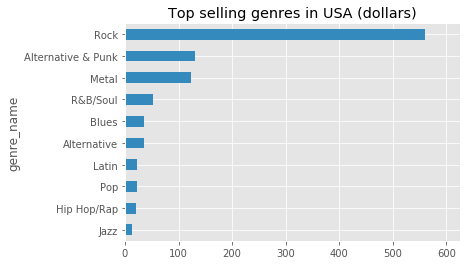

In [5]:
df1.set_index('genre_name', inplace=True)

df1['sale_number'].sort_values(ascending=True).plot.barh(
    title='Top selling genres in USA (dollars)',
    xlim=(0,625),
    color=list(plt.rcParams['axes.prop_cycle'])[1]['color']
)
plt.show()

This chart shows that `rock` is significantly more popular than other genres. Additionally, `Alternative & Punk` and `Metal` music also indicate a high popularity given their sales volumes.

## Measuring employee performance

In [6]:
q2 = """SELECT e.first_name || ' ' || e.last_name AS employee_name,
               SUM(i.total) AS total_sales,
               e.hire_date
          FROM employee AS e
               LEFT JOIN customer AS c
               ON c.support_rep_id = e.employee_id
             
               LEFT JOIN invoice AS i
               ON i.customer_id = c.customer_id
         WHERE e.title = 'Sales Support Agent'
         GROUP BY 1
         ORDER BY 2 DESC
"""
run_query(q2)

,employee_name,total_sales,hire_date
0,Jane Peacock,1731.51,2017-04-01 00:00:00
1,Margaret Park,1584.00,2017-05-03 00:00:00
2,Steve Johnson,1393.92,2017-10-17 00:00:00


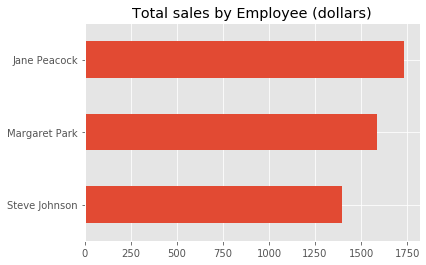

In [7]:
# visualising employee sales
employee_sales = run_query(q2)

employee_sales.set_index("employee_name", drop=True, inplace=True)
employee_sales.sort_values("total_sales", inplace=True)
employee_sales.plot.barh(
    legend=False,
    title='Total sales by Employee (dollars)',
    color=list(plt.rcParams['axes.prop_cycle'])[0]['color']
)
plt.ylabel('')
plt.show()

This chart shows that there is a degree of discrepancy between the employees. However, by taking into account the date of hire we can see the longer an employee has been there, the higher their total sales are.

## Market opportunities by country

In [8]:
qry_data_by_country="""

WITH group_others AS
    (SELECT CASE
               WHEN (
                     SELECT COUNT(customer_id)
                     FROM customer
                     WHERE country = c.country
                    ) = 1 THEN "Other"
               ELSE c.country
            END AS country,
            c.customer_id,
            i.invoice_id,
            i.total       
       FROM customer AS c
            LEFT JOIN invoice AS i
            ON i.customer_id = c.customer_id
    )
    
SELECT country,
       COUNT(DISTINCT customer_id) AS customer_count,
       SUM(total) AS sales_volume,
       ROUND(SUM(total) / COUNT(DISTINCT customer_id), 2) AS avg_customer_value,
       ROUND(SUM(total) / COUNT(DISTINCT invoice_id), 2) AS avg_order_value
  FROM (SELECT go.*,
               CASE WHEN go.country = 'Other'
                    THEN 1
                    ELSE 0
                END AS sort
          FROM group_others as go)
 GROUP BY 1
 ORDER BY sort ASC, sales_volume DESC;

"""
country_data = run_query(qry_data_by_country)
country_data

,country,customer_count,sales_volume,avg_customer_value,avg_order_value
0,USA,13,1040.49,80.04,7.94
1,Canada,8,535.59,66.95,7.05
2,Brazil,5,427.68,85.54,7.01
3,France,5,389.07,77.81,7.78
4,Germany,4,334.62,83.66,8.16
5,Czech Republic,2,273.24,136.62,9.11
6,United Kingdom,3,245.52,81.84,8.77
7,Portugal,2,185.13,92.57,6.38
8,India,2,183.15,91.57,8.72
9,Other,15,1094.94,73.00,7.45


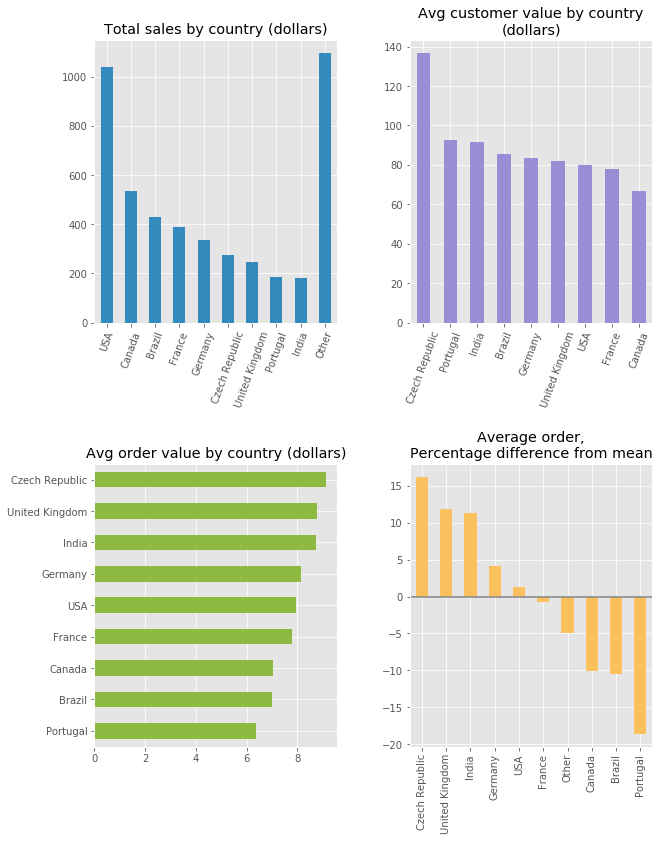

In [9]:
country_data.set_index('country', inplace=True)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,13))


ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

# top left - sales by country
sales_by_country = country_data['sales_volume'].copy()
sales_by_country.plot.bar(
    ax=ax1,
    rot=70,
    title='Total sales by country (dollars)',
    color=list(plt.rcParams['axes.prop_cycle'])[1]['color']
)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_xlabel('')


# top right - avg customer value
avg_cust_value = country_data['avg_customer_value'].copy()
avg_cust_value.drop('Other').sort_values(ascending=False).plot.bar(
    ax=ax2,
    rot=70,
    color=list(plt.rcParams['axes.prop_cycle'])[2]['color']
)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_title('Avg customer value by country\n(dollars)')
ax2.set_xlabel('')

# bottom left - avg order value
avg_order_value = country_data['avg_order_value'].copy()
avg_order_value.drop('Other').sort_values().plot.barh(
    ax=ax3,
    title='Avg order value by country (dollars)',
    color=list(plt.rcParams['axes.prop_cycle'])[5]['color']
)
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')
ax3.set_ylabel('')

# bottom right - avg order compared to mean
avg_order = country_data['avg_order_value'].copy()
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop('Other')
difference_from_avg.sort_values(ascending=False).plot.bar(
    ax=ax4,
    title='Average order,\nPercentage difference from mean',
    color=list(plt.rcParams['axes.prop_cycle'])[4]['color']
)
ax4.axhline(0, color='#828282')
ax4.yaxis.set_ticks_position('left')
ax4.xaxis.set_ticks_position('bottom')
ax4.set_xlabel('')


plt.show()

We can make the following observations from the above graph:
* The majority of total sales come from the USA
* the Czech Republic has both the highest average customer value and average order value
* Portugal and India have relatively high average customer value
* The UK and India have relatively high average order value

With these observations in mind, let's make recommendations for the business

## Recommendations for Chinook

Given the patterns found in the above analysis, we recommend Chinook undertakes the following actions:
1. Expand the market in the Czech Republic and India (and possibly Portugal or the UK)
2. In the USA, acquire more Rock, Alternative/Punk and Metal album and songs
3. No action required for employee performance

Possible further areas of analysis/action:
* Identify top artists per country (could use this to introduce new artists based on location)
* Determine popular and unpopular media types
* Identify most loyal customers and give rewards
* Explore patterns of inactive customers
* Average monthly sales of employees

Thank you for time.

\- Ben